# 支持向量机   
在SVM的优化过程中，只有支持向量对最终的决策函数有贡献，其他的点可以被忽略。     
这是因为SVM试图找到一个超平面，使得离超平面最近的点（即支持向量）到超平面的距离（即间隔）最大化。

## 线性可分的情况


数据集大小： 200


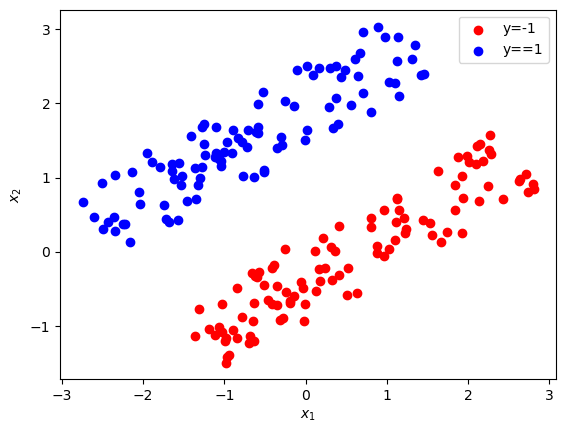

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap # 该类用于创建颜色映射
from tqdm import tqdm, trange # python进度条库

# 导入数据
data = np.loadtxt('linear.csv', delimiter=',') # 该数据集一行有三个数值，分别是x1，x2和类别y∈{-1，1}
print('数据集大小：',len(data)) # 打印行数
x = data[:,:2]
y = data[:,2]

# 数据可视化
plt.figure()
plt.scatter(x[y == -1,0],x[y == -1,1],color='red',label='y=-1') # 绘制了类别为-1的数据点，颜色为红色
plt.scatter(x[y == 1,0],x[y == 1, 1],color='blue',label='y==1') # 绘制了类别为1的数据点，颜色为蓝色
plt.xlabel(r'$x_1$') # $符号被用于标记数学表达式的开始和结束。x_1是一个下标表示法。
plt.ylabel(r'$x_2$') # r前缀表示这是一个原始字符串，它告诉Python解释器不要对字符串中的\进行转义
plt.legend() #添加了图例。
plt.show()

In [14]:
# 实现序列最小优化算法SMO 
def SMO(x,y,ker,C,max_iter):

    '''
    SMO算法
    x,y:样本的值和类别
    ker:核函数
    C:惩罚函数
    max_iter: 最大迭代次数
    '''

    # 初始化参数
    m = x.shape[0] # m是样本数量 
    alpha = np.zeros(m) # alpha是拉格朗日乘子向量，初始化为全零 

    # 预先计算所有向量的两两内积，减少重复计算
    K = np.zeros((m,m))
    for i in range(m):
        for j in range(m):
            K[i,j] = ker(x[i],x[j]) # ker为核函数(kernel Function)
            
    for l in trange(max_iter):
    # 开始迭代,外层循环控制最大迭代次数，内层循环遍历所有样本。
    # trange用于在 Python 中创建一个带有进度条的循环
        for i in range(m):
            # 有m个参数，每一轮迭代中一次更新(m个样本)
            # 随机选择一个与i不同的索引j
            j =  np.random.choice([l for l in range(m) if l!= i]) # l是列表推导式 [l for l in range(m) if l != i] 的局部变量，它的作用范围仅限于这个列表推导式,和外部循环的 l 是两个完全独立的变量

            # 用-q/2q更新alpha_i的值
            # 计算和更新拉格朗日乘子 alpha_i 和 alpha_j
            eta = K[j,j] + K[i,i] -2 * K[i,j] # 用作更新 alpha_i 的分母
            e_i = np.sum(y * alpha * K[:, i]) - y [i] # 分子 分别表示第 i 个样本和第 j 个样本的预测误差
            e_j = np.sum(y * alpha * K[:,j]) - y[j]
            alpha_i = alpha[i] + y[i] * (e_j - e_i) / (eta + 1e-5) # 防止除以0. 根据SMO算法的更新公式,计算新的 alpha_i
            zeta = alpha[i] * y[i] + alpha[j] * y[j]  # 当前 alpha_i 和 alpha_j 的线性组合，这个值在后续的计算中被用来保证约束条件的满足

            # 将alpha_i和对应的alpha_j保持在[0,c]区间，两个界限是由SVM的约束条件决定的
            # 0 <= (zeta - y_j *alpha_j) / y_i <= C
            #zeta 是当前 alpha_i 和 alpha_j 的线性组合。
            if y[i] == y[j]:  
                # 如果 y[i] 和 y[j] 相等，那么 alpha_i 的上下界由 zeta/y[i]-C 和 zeta/y[i] 决定
                lower= max(0,zeta/y[i]-C)
                upper= min(C,zeta/y[i])
            else:
                # 如果 y[i] 和 y[j] 不相等，那么 alpha_i 的上下界由 zeta/y[i] 和 zeta/y[i] +C 决定
                lower= max(0,zeta/y[i])
                upper= min(C,zeta/y[i] +C)
            alpha_i = np.clip(alpha_i,lower,upper)
            alpha_j = (zeta-y[i]*alpha_i)/y[j]

            # 更新参数
            alpha[i],alpha[j] = alpha_i,alpha_j
    return alpha

In [15]:
# 设置超参数
C = 1e8 # 设置了惩罚参数 C 的值为 1e8。在支持向量机（SVM）中，C 是一个超参数，用于控制误分类的惩罚程度 
# 由于数据完全线性可分，我们不引入松弛变量 
max_iter = 1000 # 最大迭代次数为1000次
np.random.seed(0)

alpha = SMO(x, y, ker=np.inner,C=C, max_iter=max_iter)


100%|██████████| 1000/1000 [00:14<00:00, 67.19it/s]


In [17]:
# 用alpha计算w,b和支持向量（支持向量是指那些位于或者在决策边界附近的样本点）
sup_idx = alpha > 1e-5 # 支持向量的系数不为0，找出了所有非零（或接近非零）的拉格朗日乘子的索引，这些乘子对应的样本就是支持向量。
print('支持向量个数：',np.sum(sup_idx))
w = np.sum((alpha[sup_idx] * y [sup_idx]).reshape(-1,1) * x[sup_idx],axis=0) #权重向量 w 可以表示为所有支持向量和对应的拉格朗日乘子以及类别标签的乘积之和。
wx = x @ w.reshape(-1,1) #计算了所有样本和权重向量 w 的内积，结果存储在 wx 中。
b = -0.5 * (np.max(wx[y == -1]) + np.min(wx[y == 1])) #计算了SVM的偏置项 b。在这里，b 被选择为负类样本的最大分数和正类样本的最小分数的中点，以确保最大化间隔。
print('参数：',w,b)


支持向量个数： 6
参数： [-1.0211867   1.66445549] -1.312702097039547


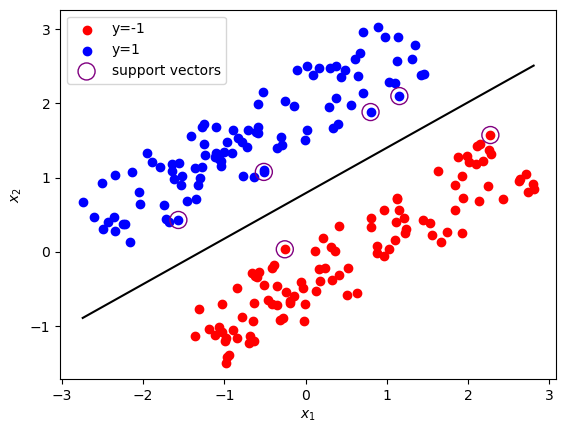

In [21]:
# 绘图
X = np.linspace(np.min(x[:,0]),np.max(x[:,0]),100)
Y = -(w[0] * X +b) / (w[1] + 1e-5)  # Y 是对应的 y 坐标，它们满足决策边界的方程 w[0]*x + w[1]*y + b = 0。

plt.figure()
plt.scatter(x[y==-1,0],x[y==-1,1],color='red',label='y=-1')
plt.scatter(x[y==1,0],x[y==1,1],color='blue',label='y=1')
plt.plot(X,Y,color='black') # 绘制了决策边界

plt.scatter(x[sup_idx,0],x[sup_idx,1],marker='o',color='none',edgecolors='purple',s=150,label='support vectors') #  用圆圈标记出支持向量

plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend()
plt.show()


In [4]:
import numpy as np
x = np.array([1,2])
x.shape[0]

2